In [90]:
#import functions / classes from helper and text_pipeline script 
from helpers import prepare_df, calc_scores, check_class_balance, downsample, hard
from text_pipeline import TextPrep

#all appropriate imports
import pandas as pd
import dataframe_image as dfi
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import pickle 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout


In [2]:
#load in dataframe
reviews = pd.read_csv('../data/yelp.csv', index_col=0)
#then use the prepare_df function to clean the dataframe and make our three classes (ranked 1-3) 
reviews = prepare_df(reviews)

/Users/user/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [3]:
#next, going to split the entire dataframe into train and holdout
df_train, df_holdout = train_test_split(reviews)
#lets use the imported check class balance function
labels = [1, 2, 3]
check_class_balance(df_train, 'stars', labels=labels)
#we can see that class3 ('Good') greatly outnumbers the rest 

{'total': 118818, 1: 19651, 2: 19713, 3: 79454}

In [55]:
len(df_train), len(df_holdout)

(58953, 39606)

In [4]:
#going to use the imported downsample function 
df_train = downsample(df_train, 'stars')
#sanity check
check_class_balance(df_train, 'stars', labels=labels)

{'total': 58953, 1: 19651, 2: 19651, 3: 19651}

In [27]:
#import the TextPrep class which instatiates an NLP pipeline for a dataframe, 
#including a vectorize method which takes a method and a column name as a parameter 
pipeline = TextPrep(df_train)
X = pipeline.vectorize('text', method='token')
y = pd.get_dummies(df_train['stars']).values
#the pipeline has a documents attribute which has a list of raw documents

In [26]:
# #create another pipeline for the un-undersampled holdout
pipeline_holdout = TextPrep(df_holdout)
X_holdout = pipeline_holdout.vectorize('text', method='token')
y_holdout = pd.get_dummies(df_holdout['stars']).values


In [28]:
#now split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [8]:
#first:establish a baseline, which is if prediction was just random (each class with equal probability)
#then use the imported calc_scores function which returns a list of precision, accuracy, and recall score
baseline = []
for i in range(len(y)):
    baseline.append(np.random.choice([1, 2, 3]))
baseline = np.array(baseline)
baseline_scores = calc_scores(baseline, y)

Precision : 0.33272267738707106 
Accuracy : 0.33272267738707106 
Recall: 0.33272267738707106


In [96]:
#next let's build layers of  lstm model

model = Sequential()
model.add(Embedding(50000, 100, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.4, recurrent_dropout=0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 303       
Total params: 5,080,703
Trainable params: 5,080,703
Non-trainable params: 0
_________________________________________________________________


In [60]:
epochs=3
batch_size=64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=.2, 
                   callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=.0001)])

Epoch 1/3
553/553 [==============================] - 632s 1s/step - loss: 0.8928 - accuracy: 0.5507 - val_loss: 0.6944 - val_accuracy: 0.6960
Epoch 2/3
553/553 [==============================] - 591s 1s/step - loss: 0.5864 - accuracy: 0.7501 - val_loss: 0.6701 - val_accuracy: 0.7082
Epoch 3/3
553/553 [==============================] - 670s 1s/step - loss: 0.4686 - accuracy: 0.8114 - val_loss: 0.6928 - val_accuracy: 0.7007


In [63]:
#now lets test the model's predictions 
#since the lstm model is a soft classifier, 
#use the imported hard function to harden the predictions 
y_hat = hard(model.predict(X_test))
test_scores = calc_scores(hard(y_test), y_hat)

Precision : 0.7045932559875161 
Accuracy : 0.7045932559875161 
Recall: 0.7045932559875161


In [62]:
final_hat = hard(model.predict(X_holdout))
final_scores = calc_scores(hard(y_holdout), final_hat)

Precision : 0.29937383224763925 
Accuracy : 0.29937383224763925 
Recall: 0.29937383224763925


In [65]:
#severly overfitting....should i try not to undersample? 
df_train2, df_holdout2 = train_test_split(reviews)

In [70]:
pipeline2 = TextPrep(df_train2)
X2 = pipeline2.vectorize('text', method='token')
y2 = pd.get_dummies(df_train2['stars']).values
pipeline_holdout2 = TextPrep(df_holdout2)
X_holdout2 = pipeline_holdout2.vectorize('text', method='token')
y_holdout2 = pd.get_dummies(df_holdout2['stars']).values

In [71]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2)


In [97]:
epochs=5
batch_size=64
history = model.fit(X2_train, y2_train, epochs=epochs, batch_size=batch_size, validation_split=.2, 
                   callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=.0001)])

Epoch 1/5
1114/1114 [==============================] - 1466s 1s/step - loss: 0.6834 - accuracy: 0.7296 - val_loss: 0.5187 - val_accuracy: 0.7890
Epoch 2/5
1114/1114 [==============================] - 1139s 1s/step - loss: 0.4631 - accuracy: 0.8142 - val_loss: 0.4868 - val_accuracy: 0.8053
Epoch 3/5
1114/1114 [==============================] - 1114s 1000ms/step - loss: 0.4062 - accuracy: 0.8391 - val_loss: 0.5171 - val_accuracy: 0.8048
Epoch 4/5
1114/1114 [==============================] - 1181s 1s/step - loss: 0.3548 - accuracy: 0.8593 - val_loss: 0.5127 - val_accuracy: 0.8084
Epoch 5/5
1114/1114 [==============================] - 1216s 1s/step - loss: 0.3242 - accuracy: 0.8712 - val_loss: 0.5378 - val_accuracy: 0.8044


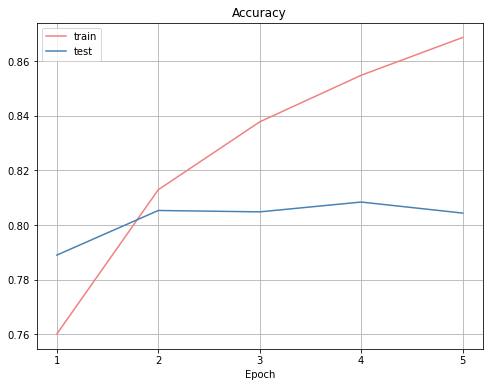

In [98]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Accuracy')
ax.plot(history.history['accuracy'], label='train', color='lightcoral')
ax.plot(history.history['val_accuracy'], label='test', color='steelblue')
ax.set_xlabel('Epoch')
ax.set_xticks(np.arange(5))
ax.set_xticklabels(np.arange(1, 6))
ax.legend()
ax.grid()
plt.savefig('../img/accr.png')

In [80]:
model.evaluate(X2_test, y2_test)

929/929 [==============================] - 110s 119ms/step - loss: 0.4842 - accuracy: 0.8082


[0.48419684171676636, 0.8082141280174255]

In [81]:
model.evaluate(X_holdout2, y_holdout2)

1238/1238 [==============================] - 165s 133ms/step - loss: 1.2730 - accuracy: 0.5845


[1.2729711532592773, 0.5844821333885193]

In [82]:
final_hat = hard(model.predict((X_holdout2)))

In [87]:
lstm_test_hat = hard(model.predict(X2_test))
lstm_test_scores = calc_scores(hard(y2_test), lstm_test_hat)
lstm_scores = calc_scores(hard(y_holdout2), final_hat)

Precision : 0.8082141053694665 
Accuracy : 0.8082141053694665 
Recall: 0.8082141053694665
Precision : 0.5844821491693177 
Accuracy : 0.5844821491693177 
Recall: 0.5844821491693177


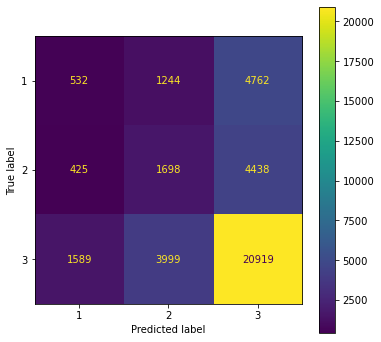

In [86]:
fig, ax = plt.subplots(figsize=(6, 6))
conf_matrix = confusion_matrix(hard(y_holdout2), final_hat)
cfm = ConfusionMatrixDisplay(conf_matrix, display_labels=[1,2,3]).plot(ax=ax)
plt.savefig('../img/matrix.png')

In [88]:
raw_results = pd.DataFrame({'Baseline':[.334530, .334350, .334354], 
                       'Logistic Test': [.5080, .5207, .4666], 
                       'Logitic Final': [.5101, .5298, .4695], 
                       'Random Forest Test':[.4637, .4671, .3622], 
                       'Random Forest Final':[.4687, .4689, .3580], 
                       'LSTM Test':lstm_test_scores,
                        'LSTM Final':lstm_scores}, 
                          index =  ['Precision', 'Accuracy', 'Recall'])

In [92]:
dfi.export(raw_results, '../img/raw-results.png')